# Environment Setup

In [1]:
from os import chdir as cd
cd('/mnt/d/repo/CS420_Lab02_Connect-4')

# Data preparation

## Read data

In [2]:
from pandas import read_csv

data_raw = read_csv("./data/connect-4.csv", header=0)
print(data_raw)

      a1 a2 a3 a4 a5 a6 b1 b2 b3 b4  ... f4 f5 f6 g1 g2 g3 g4 g5 g6 class
0      b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
1      b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
2      b  b  b  b  b  b  o  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
3      b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
4      o  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b   win
...   .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. ..   ...
67552  x  x  b  b  b  b  o  x  o  b  ...  b  b  b  o  o  x  b  b  b  loss
67553  x  x  b  b  b  b  o  b  b  b  ...  b  b  b  o  x  o  o  x  b  draw
67554  x  x  b  b  b  b  o  o  b  b  ...  b  b  b  o  x  x  o  b  b  loss
67555  x  o  b  b  b  b  o  b  b  b  ...  b  b  b  o  x  o  x  x  b  draw
67556  x  o  o  o  x  b  o  b  b  b  ...  b  b  b  x  b  b  b  b  b  draw

[67557 rows x 43 columns]


## Preprocessing Data

In [3]:
data_feature = data_raw.iloc[:, :-1]
data_label = data_raw.iloc[:, -1:]

In [4]:
feature_names = data_feature.columns
class_names = ['draw', 'loss', 'win']

In [5]:
x = data_feature.to_numpy()
y = data_label.to_numpy()

In [6]:
for i in range( 0, len( x[:] ) ):
    for j in range( 0, len( x[i][:] ) ):
        if x[i][j] == 'b':
            x[i][j] = -1
        elif x[i][j] == 'x':
            x[i][j] = 0
        elif x[i][j] == 'o':
            x[i][j] = 1
        else:
            print(x[i][j])
            raise Exception("Invalid Value")

## Train/Test Separation with Different Proportions

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

train_propotions = [0.4, 0.6, 0.8, 0.9]
datasets = []

for prop in train_propotions:
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=prop)
    
    for train_idx, test_idx in splitter.split(x, y):
        feature_train, label_train = x[train_idx], y[train_idx]    
        feature_test, label_test = x[test_idx], y[test_idx]
             
        datasets.append(
            {
                "feature_train" : feature_train,
                "label_train" : label_train,
                "feature_test" : feature_test,
                "label_test" : label_test
            }
        )

# Decision Tree Classifier

## Modelling and Visualization

In [8]:
from sklearn.tree import DecisionTreeClassifier

dec_trees = []
for dataset in datasets:
    dec_tree = DecisionTreeClassifier(criterion='entropy')
    
    dec_tree = dec_tree.fit(dataset["feature_train"], dataset["label_train"])
    
    dec_trees.append(dec_tree)

In [9]:
from sklearn.tree import export_graphviz
from graphviz import Source

for dec_tree in dec_trees:
    idx = dec_trees.index(dec_tree)
    corr_prop = train_propotions[idx]
    
    filename = f"tree-{corr_prop}_Full"
    
    doc_data = export_graphviz(
        dec_tree,
        feature_names=feature_names,
        class_names=class_names,
        filled=True)
    
    Source(doc_data).render(filename=filename, format='svg')

## Evaluation

              precision    recall  f1-score   support

        draw       0.25      0.26      0.26      3870
        loss       0.63      0.63      0.63      9981
         win       0.84      0.84      0.84     26684

    accuracy                           0.73     40535
   macro avg       0.57      0.57      0.57     40535
weighted avg       0.73      0.73      0.73     40535

              precision    recall  f1-score   support

        draw       0.28      0.30      0.29      2580
        loss       0.67      0.66      0.67      6654
         win       0.85      0.85      0.85     17789

    accuracy                           0.75     27023
   macro avg       0.60      0.60      0.60     27023
weighted avg       0.76      0.75      0.75     27023

              precision    recall  f1-score   support

        draw       0.26      0.28      0.27      1290
        loss       0.67      0.66      0.67      3327
         win       0.85      0.85      0.85      8895

    accuracy        

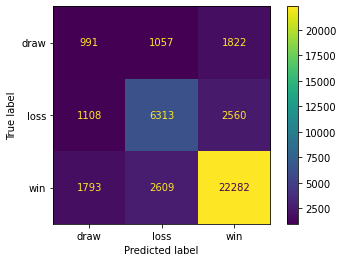

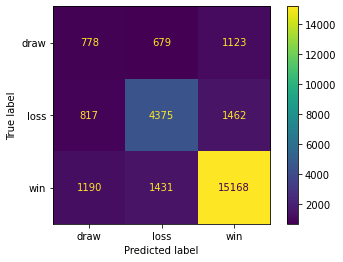

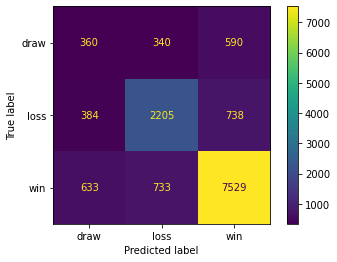

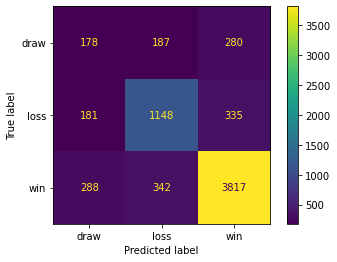

In [10]:
from numpy import concatenate
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay
)

for dec_tree, dataset in zip(dec_trees, datasets):
    pred = dec_tree.predict(dataset["feature_test"])
    ground_truth = concatenate(dataset["label_test"])
    
    print( classification_report(ground_truth, pred, labels=class_names) )
    
    ConfusionMatrixDisplay.from_predictions(ground_truth, pred, labels=class_names)

# Evaluating Tree Depth and Accuracy

In [11]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import accuracy_score
from graphviz import Source
from numpy import concatenate

dataset = datasets[2]

max_depths = (None, 2, 3, 4, 5, 6, 7)
for max_depth in max_depths:
    dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    dec_tree = dec_tree.fit(dataset["feature_train"], dataset["label_train"])
    
    filename = f"tree-{0.8}_Depth-{max_depth}"
    
    doc_data = export_graphviz(
        dec_tree,
        feature_names=feature_names,
        class_names=class_names,
        filled=True)
    
    Source(doc_data).render(filename=filename, format='svg')
    
    pred = dec_tree.predict(dataset["feature_test"])
    ground_truth = concatenate(dataset["label_test"])
    
    print( accuracy_score(ground_truth, pred) )
    

0.7484458259325044
0.658303730017762
0.6635583185316756
0.6756216696269982
0.6894612196566016
0.6932356423919479
0.7030047365304914
